In [21]:
import xarray as xr
import numpy as np
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
reanalysis = xr.open_zarr(
    "gs://gcp-public-data-arco-era5/co/single-level-reanalysis.zarr",
    chunks={"time": 48},
    consolidated=True,
)

/var/folders/zz/ztx12x896vd573v9kj5ckz980000gp/T/ipykernel_24605/165558829.py:1: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  reanalysis = xr.open_zarr(


In [15]:
def mirror_point_at_360(ds):
    extra_point = ds.where(ds.longitude == 0, drop=True).assign_coords(
        longitude=lambda x: x.longitude + 360
    )
    return xr.concat([ds, extra_point], dim="values")


def build_triangulation(x, y):
    grid = np.stack([x, y], axis=1)
    return Delaunay(grid)

In [5]:
grid = xr.open_dataset(
    "/Users/dgagne/data/CREDIT_data/LSM_static_variables_ERA5_zhght.nc"
)

/var/folders/zz/ztx12x896vd573v9kj5ckz980000gp/T/ipykernel_24605/2116885116.py:1: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  grid = xr.open_dataset("/Users/dgagne/data/CREDIT_data/LSM_static_variables_ERA5_zhght.nc")


In [7]:
lon_f = grid["longitude"].values
lat_f = grid["latitude"].values
mesh = np.stack(np.meshgrid(lon_f, lat_f, indexing="ij"), axis=-1)

In [28]:
ds_feb20 = (
    reanalysis.sel(time=slice("2020-02-01", "2020-02-02"))
    .compute()
    .pipe(mirror_point_at_360)
)

In [29]:
lon = ds_feb20["longitude"].values
lat = ds_feb20["latitude"].values
tri = build_triangulation(lon, lat)

In [30]:
indices = tri.find_simplex(mesh)

In [32]:
ndim = tri.transform.shape[-1]
T_inv = tri.transform[indices, :ndim, :]
r = tri.transform[indices, ndim, :]
c = np.einsum("...ij,...j", T_inv, mesh - r)

In [134]:
tri.transform

np.float64(-89.78487690721863)

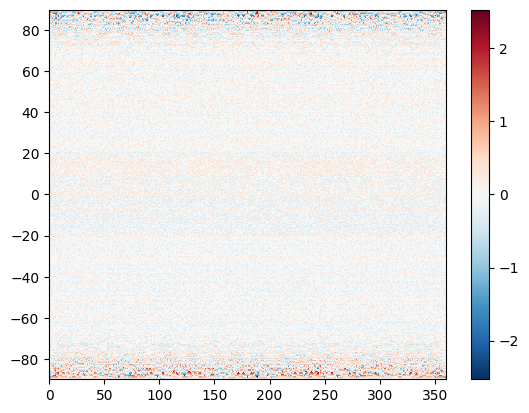

In [141]:
plt.pcolormesh(lon_f, lat_f, (mesh - r)[:, :, 1].T, cmap="RdBu_r")
plt.colorbar()

In [143]:
c.min()

np.float64(-8.881784197001252e-16)

In [48]:
c2 = np.concatenate([c, 1 - c.sum(axis=-1, keepdims=True)], axis=-1)

In [50]:
c2.shape

(1280, 640, 4)

In [66]:
data = ds_feb20["z"].values

In [67]:
c = np.einsum("...ij,...j", T_inv, mesh - r)
c = np.concatenate([c, 1 - c.sum(axis=-1, keepdims=True)], axis=-1)
result = np.einsum("...i,...i", data[:, tri.simplices[indices]], c)

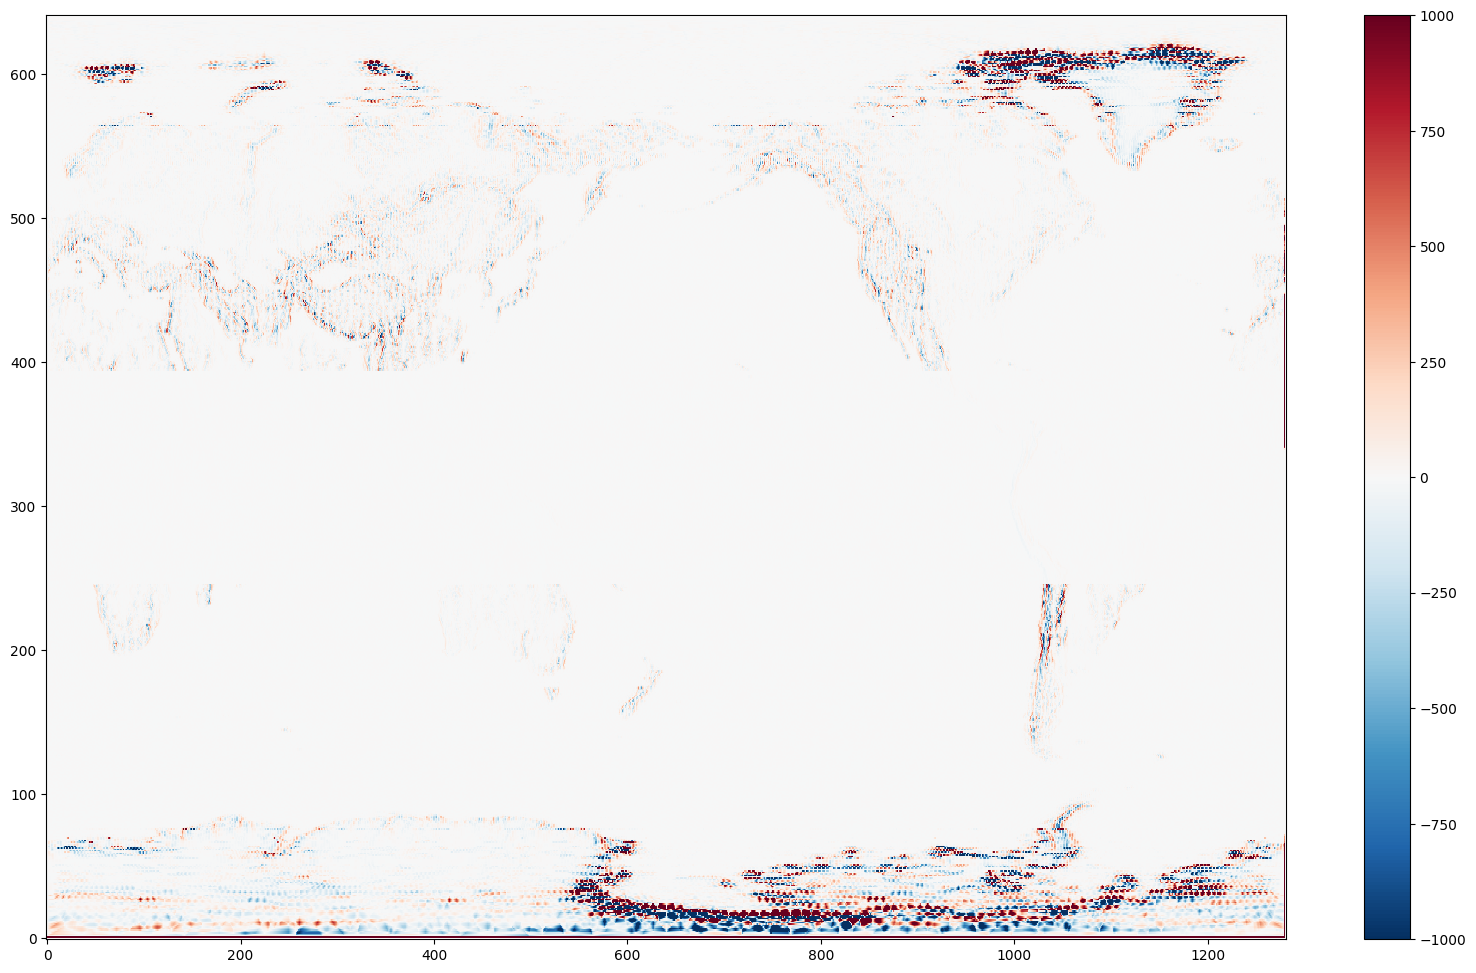

In [104]:
plt.figure(figsize=(20, 12))
plt.pcolormesh(
    (result[0].T - grid["Z_GDS4_SFC"])[::-1], cmap="RdBu_r", vmin=-1000, vmax=1000
)
plt.colorbar()
plt.ylim(-1, 641)
plt.xlim(-1, 1281)
plt.savefig("terrain_interp_errors.png", dpi=300, bbox_inches="tight")

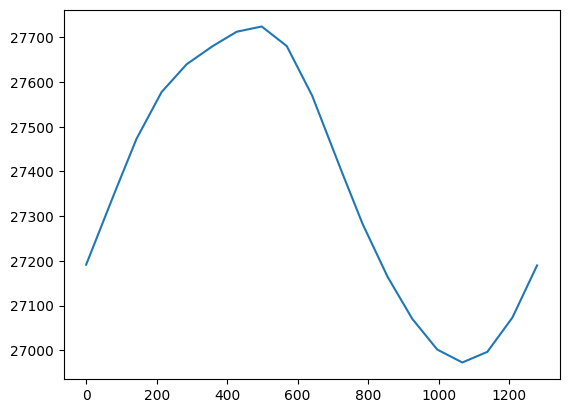

In [94]:
plt.plot(result[0].T[-1] - grid["Z_GDS4_SFC"][-1].values)

In [80]:
grid["Z_GDS4_SFC"][-1].values

array([0., 0., 0., ..., 0., 0., 0.], shape=(1280,))

In [ ]:
def interpolate(data, tri, mesh):
    indices = tri.find_simplex(mesh)
    ndim = tri.transform.shape[-1]
    T_inv = tri.transform[indices, :ndim, :]
    r = tri.transform[indices, ndim, :]
    c = np.einsum("...ij,...j", T_inv, mesh - r)
    c = np.concatenate([c, 1 - c.sum(axis=-1, keepdims=True)], axis=-1)
    result = np.einsum("...i,...i", data[:, tri.simplices[indices]], c)
    return np.where(indices == -1, np.nan, result)

In [144]:
def lonlat_to_cartesian(lon, lat, radius=6371.229):
    x = radius * np.cos(np.radians(lon)) * np.cos(np.radians(lat))
    y = radius * np.cos(np.radians(lat)) * np.sin(np.radians(lon))
    z = radius * np.sin(np.radians(lat))
    return x, y, z


def interpolate_3d(data, tri_3d, mesh):
    return

In [145]:
x, y, z = lonlat_to_cartesian(lon, lat)

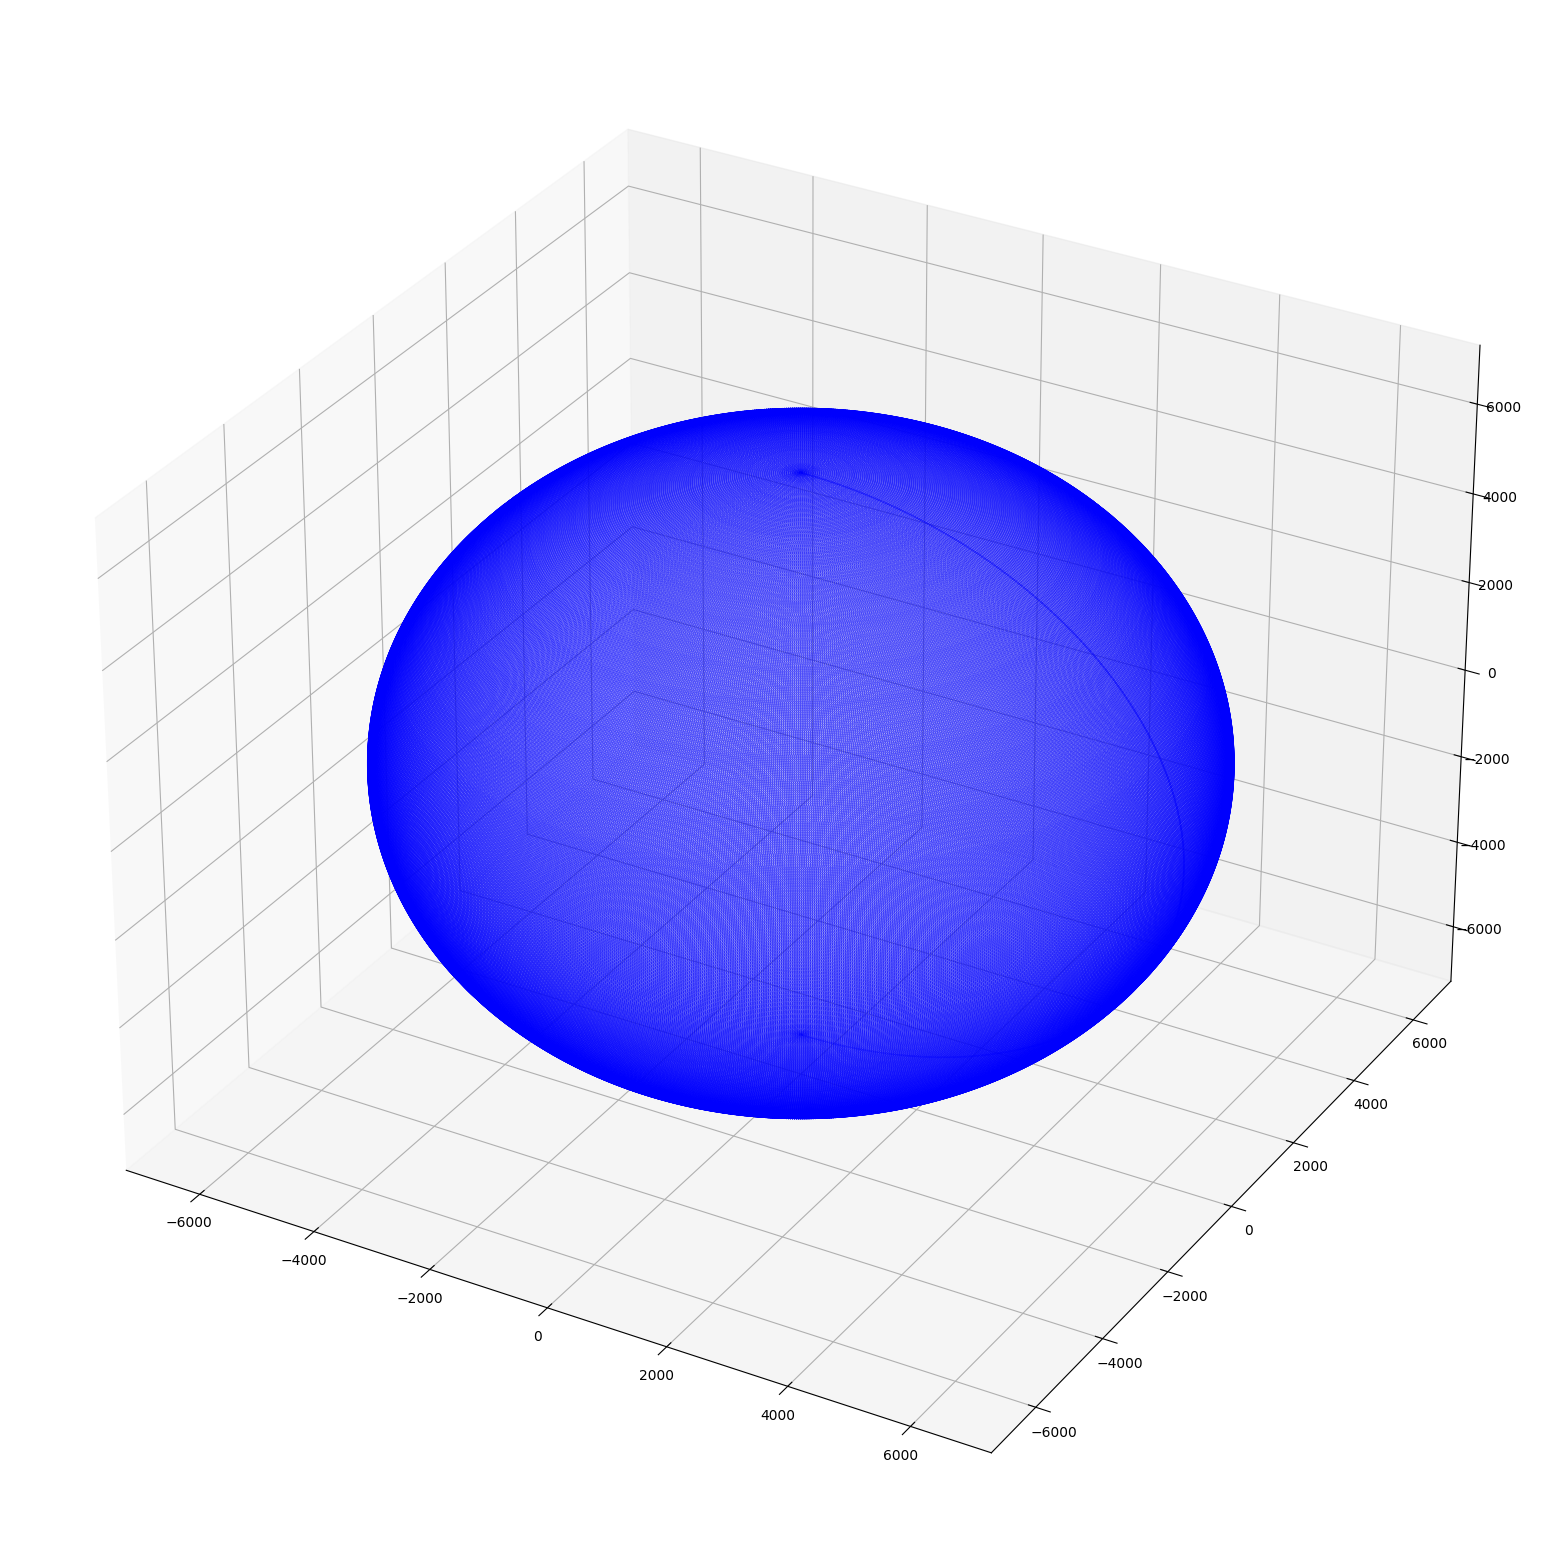

In [149]:
ax = plt.figure(figsize=(20, 20)).add_subplot(projection="3d")
ax.scatter(x, y, zs=z, s=0.1, c="b")

In [ ]:
lon_3d = reanalysis.longitude.values
lat_3d = reanalysis.latitude.values
x, y, z = lonlat_to_cartesian(lon_3d, lat_3d)


def build_triangulation_3d(x, y, z):
    grid = np.stack([x, y, z], axis=1)
    return Delaunay(grid)


tri_3d = build_triangulation_3d(x, y, z)

In [ ]:
tri_3d

In [3]:
path = "https://storage.googleapis.com/gcp-public-data-arco-era5/raw/date-variable-single_level/2025/01/01/land_sea_mask/surface.nc"
import fsspec
import xarray as xr

with fsspec.open(path, mode="rb") as fid:
    dataset = xr.open_dataset(fid, engine="scipy", cache=False)

In [5]:
dataset["lsm"]

<xarray.DataArray 'lsm' (time: 24, latitude: 721, longitude: 1440)> Size: 199MB
[24917760 values with dtype=float64]
Coordinates:
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 192B 2025-01-01 ... 2025-01-01T23:00:00
Attributes:
    units:          (0 - 1)
    long_name:      Land-sea mask
    standard_name:  land_binary_mask